## Library Imports

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
#import pillow as pil
%matplotlib inline

## Create image pre-processing function

In [2]:
# Function to preprocess the image with Keras
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

## Load the metadata file.  Create a ground truth column.

In [3]:
# Load the metadata file
metadata = pd.read_excel('metadata_modified.xlsx')
image_path = metadata['Image Path']
# Create the ground truth values and put it into a new 'g_truth' column
g_truth = metadata['Malignant'] + metadata['A']*2 + metadata['F']*4 + metadata['PT']*8 + metadata['TA']*16 + metadata['DC']*32 + metadata['LC']*64 + metadata['MC']*128 + metadata['PC']*256
metadata['g_truth'] = g_truth

## Display a random test image

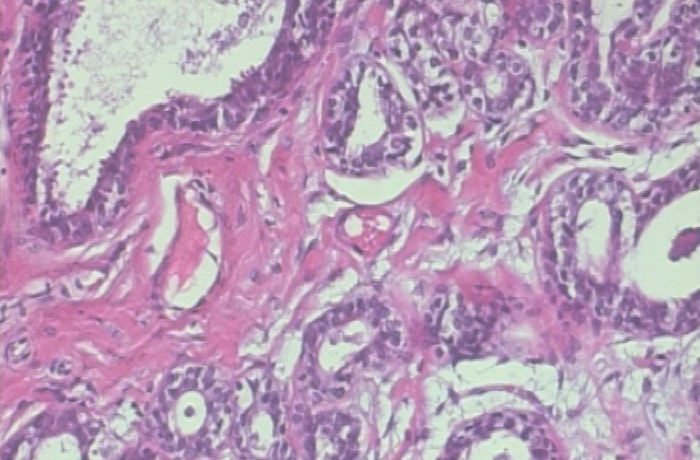

In [4]:
# Display test image
from IPython.display import Image
random_index = np.random.randint(0,7177)
Image(filename=image_path[random_index], width=300,height=200)

In [5]:
mobile_v3 = tf.keras.applications.MobileNetV3Large()

## Define the training and validation datasets

In [6]:
path_to_files = 'BreaKHis_v1/histology_slides/breast/'
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_files,
  validation_split=0.25,
  subset="training",
  seed=42,
  image_size=(224, 224),
#  batch_size=32,
  shuffle=True
)
  
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_files,
  validation_split=0.25,
  subset="validation",
  seed=42,
  image_size=(224, 224),
#  batch_size=32,
  shuffle=True
)
val_batches = tf.data.experimental.cardinality(val_dataset)
val_dataset = val_dataset.take((2*val_batches) // 5)
test_dataset = val_dataset.skip((2*val_batches) // 5)

Found 7909 files belonging to 8 classes.
Using 5932 files for training.
Found 7909 files belonging to 8 classes.
Using 1977 files for validation.


## Use AUTOTUNE to decrease I/O roadblocks

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Define the model

In [9]:
IMG_SIZE=(224,224)
IMG_SHAPE = IMG_SIZE + (3,)
def fine_model (image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                                        include_top=False, 
                                                        weights='imagenet')
    # freeze the base model
    base_model.trainable = True
    # fine tune from this layer onwards
    fine_tune = 210
    # Freeze all the layers before the `fine_tune` layer
    for layer in base_model.layers[:fine_tune]:
        layer.trainable = False
    # create input layer
    inputs = tf.keras.Input(shape=input_shape)
    # pre-process inputs
    x = preprocess_input(inputs)
    # set training to False to avoid tracking statistics in batch norm layer
    x = base_model(x, training=False)
    # add flatten layer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(8, activation='softmax')(x)
    outputs = x

    model = tf.keras.Model(inputs,outputs)
    return model

## Train the model

In [10]:
project_model = fine_model(IMG_SIZE)
project_model.summary()
len(project_model.layers[1].layers)            # get the number of layers in the model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 47040)             0         
                                                                 
 dropout_1 (Dropout)         (None, 47040)             0         
                                                                 
 dense (Dense)               (None, 8)                 376328    
                                                                 
Total params: 3372680 (12.87 MB)
Trainable params: 2126888 (8.11 MB)
Non-trainable params: 1245792 (4.75 MB)
__________________

263

In [11]:
IMG_SIZE=(224,224)
IMG_SHAPE = IMG_SIZE + (3,)
project_model = fine_model(IMG_SIZE)
base_learning_rate = 0.001
opt = tf.keras.optimizers.legacy.SGD(learning_rate=base_learning_rate, momentum=0.9, nesterov=True)
project_model.compile(optimizer=opt,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

epochs = 10
history = project_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/10
186/186 [==============================] - 53s 278ms/step - loss: 1.6464 - accuracy: 0.4562 - val_loss: 1.2177 - val_accuracy: 0.5625
Epoch 2/10
186/186 [==============================] - 52s 276ms/step - loss: 1.0174 - accuracy: 0.6318 - val_loss: 1.0831 - val_accuracy: 0.6172
Epoch 3/10
186/186 [==============================] - 52s 278ms/step - loss: 0.6842 - accuracy: 0.7535 - val_loss: 0.8832 - val_accuracy: 0.6875
Epoch 4/10
186/186 [==============================] - 52s 277ms/step - loss: 0.4647 - accuracy: 0.8346 - val_loss: 0.9563 - val_accuracy: 0.6979
Epoch 5/10
186/186 [==============================] - 55s 293ms/step - loss: 0.3112 - accuracy: 0.8970 - val_loss: 1.4653 - val_accuracy: 0.6237
Epoch 6/10
186/186 [==============================] - 54s 286ms/step - loss: 0.2437 - accuracy: 0.9189 - val_loss: 0.9170 - val_accuracy: 0.7201
Epoch 7/10
186/186 [==============================] - 52s 279ms/step - loss: 0.1701 - accuracy: 0.9469 - val_loss: 0.8574 - val_ac

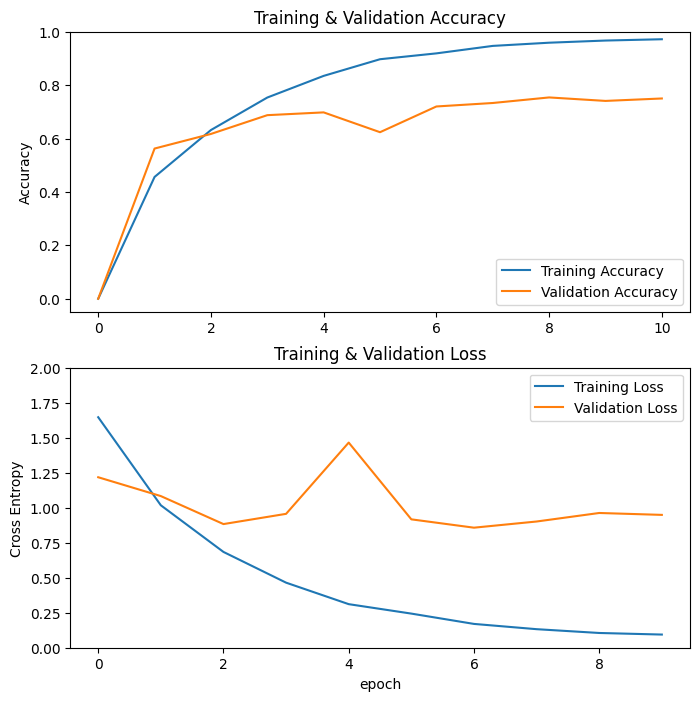

In [12]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training & Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training & Validation Loss')
plt.xlabel('epoch')
plt.show()